<img src="./foreclosure.jpg" />

# A Look At Fannie Mae Foreclosures

The total value of real estate owned by individuals in the United States is over $24 trillion dollars.  Of that enormous sum, roughly $10 trillion is in the form of mortgages. For many, owning a house is a key part of their wealth generation strategy because values reliably appreciate.  However, confidence in this system was shaken during the 2007-2009 subprime mortgage crisis when hundreds of thousands of borrowers failed to make timely payments on their mortgages and their were homes foreclosed on.  Many factors led to this collapse - an over-leveraged mortgage backed security market, lax lending rules (i.e. No Income, No Job, No Asset NINJA loans), and a bubble mentality where people feel compelled to jump on the train before it leaves the station.  In the fallout of this catastrophe, shockwaves propagated through the financial markets and wiped out trillions of dollars in value.  Those individuals that did not default saw their property values halved and retirement accounts decimated.  Many banks sought federal bailout money to cover the ensuing liquidity crisis, were absorbed by larger institutions, or went bankrupt.

While much of the systematic risk has been addressed, foreclosures still take a toll on lenders.  When a borrower defaults on their mortgage a bank isn't just hit with the burden of dealing with the initial foreclosure process.  They must also maintain the properties and eventually sell them, potentially at a loss.  If steps can be taken to avoid lending to customers who may default in the future by improving screening criteria, consumers may avoid a nasty stain on their credit history and financial institutions can avoid unnecessary risk.

Here, I take all of the publicly available Fannie Mae mortgage data and: 

 -  clean it.
 -  explore the characteristics of borrowers who default and those that don't.
 -  use machine learning tools to better detect likely defaults.

The goal is to identify mortgages *at the time of acquisition* that are likely to default and enter foreclosure.  In a later project I may try to analyze customer payment history to identify mortgages that may need to be offloaded to reduce risk in a portfolio, but for now let's imagine we are in a position to chose which mortgages to buy from another lender.  The code itself is commented to provide a summary of the analysis for those specifically interested in that aspect of the project, but additional detail and discussion is given in the text.

## Exploring the Data

The routines used to do the heavy lifting (like setting up and running the classifiers) in this analysis are contained within predict_foreclosure.py, so we need to import it along with matplotlib, pandas, and seaborn. The file setup_data_reduction.py contains initialization information and a few dictionaries to help us along the way.

In [21]:
#import routines and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from predict_foreclosure import *
from setup_data_reduction import *

#import scikit-learn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fannie Mae publishes quarterly data on loan acquisitions and performance.  The entire dataset is ~232 GB and has ~2 billion lines that need to be processed.  While it isn't monstrous,  it is too large to handle directly.  Therefore, the important data is compiled into a single file with reduce_data.py before beginning this analysis.  This routine serves to clean and trim the data, calculate a few values that will be useful later like the loan age, and identify loans that were foreclosed on.  A few of the files are so large they cannot be completely read into memory so "chunking" is used in the read_table function.  Additionally, there is a good bit of time consuming sorting and searching through the dataframes.  If this routine is run, it will take several hours, so let it run overnight.  It will then produce a file called 'reduced_data.csv' that is read in below.

In [2]:
# Read in loan data
data = pd.read_table(DATA_DIR+DATA_FILE, sep=",")
for column in ['zip', 'first_time_homebuyer', 'property_state', 'foreclosure']:
    data[column] = data[column].astype('category')
#data = data[data['origination_date'] > 2015.]
print 'Available data columns are: ', list(data)[:]

Available data columns are:  ['Unnamed: 0', 'id', 'interest_rate', 'balance', 'loan_term', 'origination_date', 'acquisition_date', 'ltv', 'cltv', 'borrower_count', 'dti', 'borrower_credit_score', 'first_time_homebuyer', 'occupancy_status', 'property_state', 'zip', 'insurance_percentage', 'co_borrower_credit_score', 'loan_age', 'foreclosure_date', 'recovery_costs', 'foreclosure']


Let's start by getting feel for the current housing market.  What are houses selling for, what's the range, and how leveraged are borrowers?  The most recent year for which we have complete data is 2016, so we will make a cut there.

In [3]:
description = data[data['origination_date'] > 2016][['balance', 
                             'interest_rate', 
                             'dti', 
                             'loan_term', 
                             'insurance_percentage']].describe()
print description[1:].round(2)

         balance  interest_rate    dti  loan_term  insurance_percentage
mean   235722.31           3.72  32.97     314.06                 24.82
std    119520.64           0.50   9.06      77.53                  7.16
min      8000.00           1.75   1.00      60.00                  1.00
25%    143000.00           3.50  26.00     240.00                 25.00
50%    216000.00           3.75  34.00     360.00                 25.00
75%    312000.00           4.00  41.00     360.00                 30.00
max   1203000.00           5.90  51.00     360.00                 42.00


This is a very diverse data set.  Loan balances range from \$8,000 up to \$1,203,000 with the norm being a touch over \$200,000.  The range of debt-to-income ratios goes from 1 (awesome) to ~50 (pretty extended).  The standard 30-year mortgage is overwhelmingly the most common.

Looking to the foreclosure data, we can count all of the foreclosed homes and calculate the rate at which they occur.

In [4]:
(good, default) = pd.value_counts(data['foreclosure']).astype(float)
print 'Total Defaults = ', default
print 'Default Rate   = '+'{:.1%}'.format(percentage(default, good+default))

Total Defaults =  571698.0
Default Rate   = 1.5%


For our analysis, there is both good and bad news.  We have 571,698 foreclosures to work with, which should be plenty to identify any telling characteristics.  However, they account for only 1.5% of all the mortgages created over the last two-ish decades.  This means it is rare that a mortgage defaults, so we need to account for this.  Without writing a single line of code, we can predict no homes will foreclose be correct 98.5$\%$ of the time.  While this "model" is accurate, it is not meaningful, so we need to account for this imbalance to gain any insight.

People default on their mortgages for many reasons, but they can basically be boiled down to issues: liquidity and negative equity.  Life throws people curveballs and despite the best of intentions, sometimes you can't meet your financial obligations.  When money is tight due to a recent layoff, medical issues, mounting credit card debt, etc., choices have to be made.  For some, this means letting a home mortgage enter delinquency.  Additionally, during an economic downturn, home values can drop precipitously. This leaves the borrower paying inflated payments for a home worth less than the loan.  Selling the home would realize the loss, so some home owners simply walk away to force it onto the lender.  

Quantifying and predicting who these people might be is difficult since these individual situations are surprising, even to the borrower.  Nevertheless we can use analytics to characterize groups that may have a tendency to run into liquidity issues or buy at the wrong times.  

Let's make simple box and whisker plots of the loan balances, debt-to-income ratios, primary borrower's credit scores, and loan-to-value ratios for those whose mortgages are up to date and those that have entered foreclosure.  These values are used to assess the credit worthiness of the borrow and the relative risk of the loan.  The plots show the median of the distributions (black line splitting the boxes) and the quartiles.  Blue boxes are those that haven't gone into foreclosure and orange is the foreclosed loans.

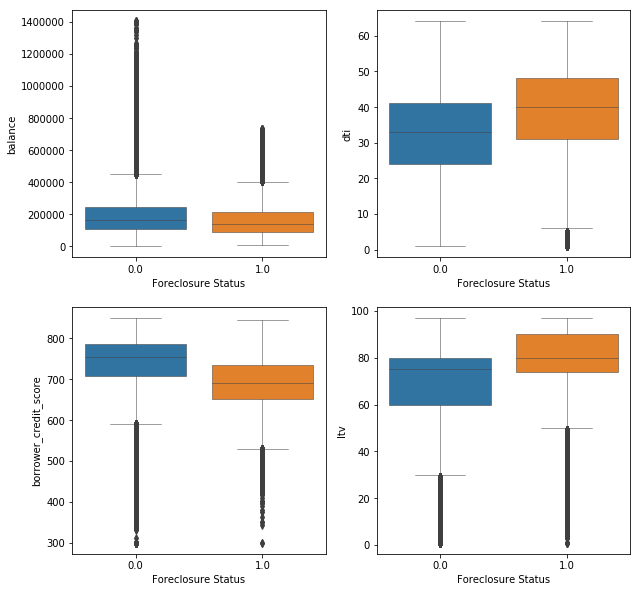

In [5]:
# Columns to plot
columns = ['balance','dti','borrower_credit_score','ltv']

# Make plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, column in zip(range(1,5), columns):
    plt.subplot(2,2,i)
    sns.boxplot(x="foreclosure", y=column, data=data, linewidth=0.5)
    plt.xlabel('Foreclosure Status')

There are indeed slight differences in the non-foreclosure and foreclosure groups.  This is encouraging.  Generally, loans that are foreclosed on initially had higher DTI and LTV ratios, and the borrowers had lower credit scores.  Still, there is substantial overlap and foreclosures can be found at all ratio levels and at very high credit scores.  It is also important to keep in mind there are almost 70 times more loans in the non-foreclosed group than the foreclosed group, so separating these two groups isn't as trivial as simply looking at these box plots.

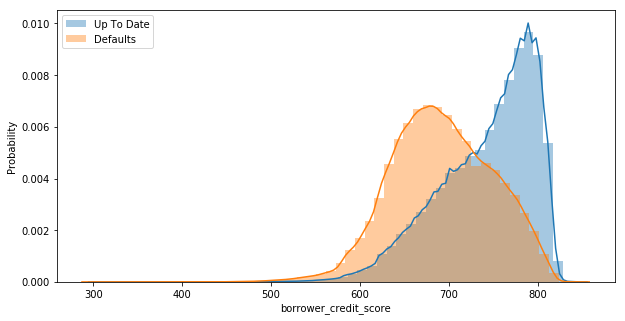

In [6]:
# Set-up plot and data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
dist_data = data[['borrower_credit_score', 'foreclosure']].dropna(axis=0, how='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data[dist_data['foreclosure']==0]
sns.distplot(good_credit_scores['borrower_credit_score'], label = 'Up To Date')

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data[dist_data['foreclosure']==1]
sns.distplot(default_credit_scores['borrower_credit_score'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

Digging into the credit score distributions a bit, we see that the defaults tend to congregate at the bottom of the credit score range.  The shapes of the distributions are quite different as well with defaults having a rightward, positive skew and the good loans concentrated at high credit scores with a leftward, negative skew.  Even if they are hard to differentiate due to their small numbers, foreclosures do seem to occupy a different population.

Histograms of the credit scores of the two groups show that the two populations are different.  Mortgages that foreclose generally have higher interest rates on the loans.  This may not be surprising because there is a moderate inverse (linear) correlation between the credit score and the loan interest rate, meaning that riskier borrowers are granted loans with higher interest rates.  

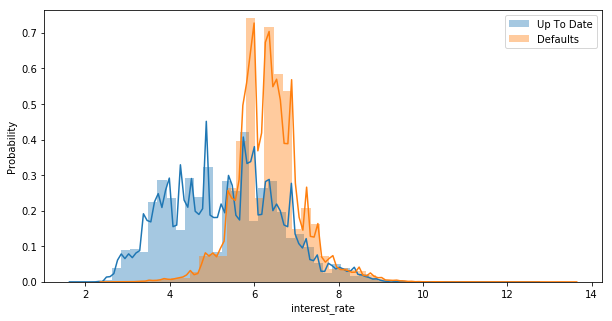

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
dist_data = data[['interest_rate', 'foreclosure']].dropna(axis=0, how='any')

good_credit_scores = dist_data[dist_data['foreclosure']==0]
sns.distplot(good_credit_scores['interest_rate'], label = 'Up To Date')

default_credit_scores = dist_data[dist_data['foreclosure']==1]
sns.distplot(default_credit_scores['interest_rate'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

In [8]:
print data['interest_rate'].corr(data['borrower_credit_score'], method='pearson')

-0.3632129724271549


Let's bring some more information into the fold.  I grew up in South Carolina, spent four years in Colorado, and now live in a suburb of DC in Maryland.  The housing markets in these areas are quite different.  Could differences in location play into the likelihood of foreclosure?

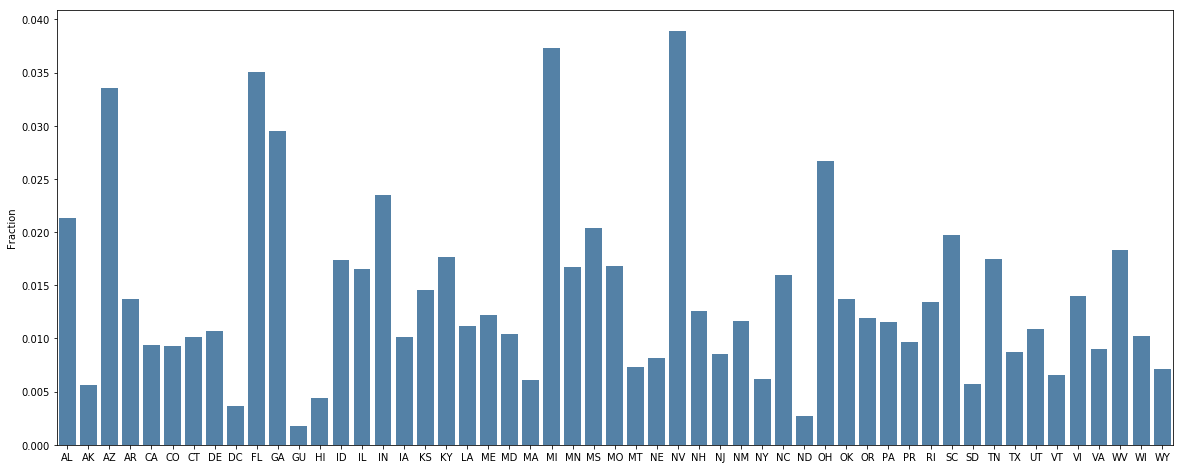

In [9]:
# Count number of mortgages per state
data['property_state'].map(VAL_TO_STATES)
states_mort = pd.value_counts(data['property_state'])

# Count number of foreclosures and get ratio
states_defaults = data[data['foreclosure']==1]
states_foreclose_count = pd.value_counts(states_defaults['property_state']).sort_index()
states_mort = pd.concat([states_mort, states_foreclose_count], axis=1).fillna(0)
states_mort.columns = ['totals','defaults']
states_mort['totals'].replace({"totals":VAL_TO_STATES})
states_mort.index = states_mort.index.to_series().map(VAL_TO_STATES)

# Plot foreclosure rates
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
sns.barplot(x=states_mort.index, y=states_mort['defaults']/states_mort['totals'], color='steelblue')
ax.set_ylabel('Fraction');

It seems like it may be important where the property is purchased.  Certain areas have much higher foreclosure rates, while others are much lower.  Bringing in outside knowledge, in certain areas there was a big rush to additional vacation homes during the subprime mortgage crisis in areas like Florida, Georgia, and Georgia.  The Las Vegas area was especially hard hit and is reflected in the very high fraction of foreclosed homes in Nevada and its large population accounts for the increased state rate of foreclosure.  The spike in foreclosures in Michigan was actually sparked by the auto industry crisis.  When looked at as a function of time, a wave of foreclosures sweeps through this area between 2009-2012, offset from the rest of the country.

The broader changes in lending and foreclosure history tell an interesting story.  Here, I have calculated the total number of newly originated loans and foreclosures in time intervals of six months for the dataset.

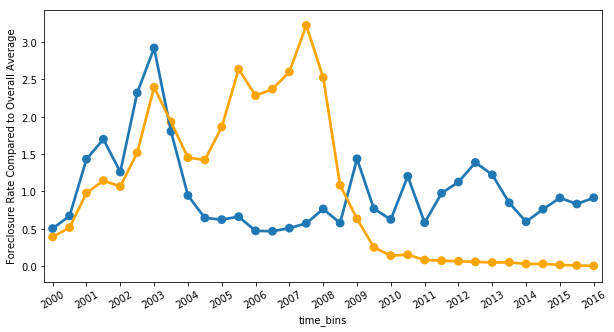

In [10]:
# Add time bin category
data['time_bins'] = pd.cut(data['origination_date'], np.arange(2000., 2017., 0.5))

# Group data by forclosure status and put into two seperate dataframes and count constituents
time_binned_good = data[data['foreclosure'] ==0].groupby(['time_bins']).count().reset_index()
time_binned_default = data[data['foreclosure'] ==1].groupby(['time_bins']).count().reset_index()

# Normlize counts to get the fraction of new mortgages and defaults with time
time_binned_good['id'] = time_binned_good['id']/time_binned_good['id'].mean()
time_binned_default['id'] = time_binned_default['id']/time_binned_default['id'].mean()

# Plot Results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.pointplot(x='time_bins', y="id", data=time_binned_good)
sns.pointplot(x='time_bins', y="id", data=time_binned_default, color = 'orange')
plt.locator_params(axis='x', nbins=18)
ax.set_xticklabels(range(2000, 2017, 1), rotation=30)
ax.set_ylabel('Foreclosure Rate Compared to Overall Average');

In the early 2000's Fannie Mae a surge of new mortgages because of national housing initiatives and the purchase of \$81 billion dollars worth of subprime securities.  In 2004-2005, some areas saw property values increase ~25$\%$.  The Federal Reserve then raised interest rates from 1$\%$ in 2004 to just over 6$\%$ in 2006.  This dramatically increased mortgage payments across the country.  The result of this confluence of events is seen as the rapid rise of foreclosures between 2000-2008.  Luckily, due to better lending standards and practices, we see the current rate is much lower and a fraction of the overall average rate.

Foreclosures don't happen instantaneously; if someone purchases a house, they are optimistic about the future.  The delay between mortgage initiation and ultimate foreclosure follows a skewed, lognormal-like distribution.

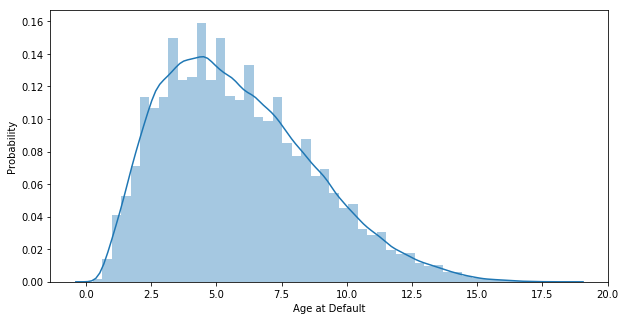

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# Clean data and plot distribution of lifetimes for defaults
age_data = data[['origination_date','foreclosure_date']].dropna(axis=0, how='any')
sns.distplot(age_data['foreclosure_date']-age_data['origination_date'])
ax.set_ylabel('Probability')
ax.set_xlabel('Age at Default');

The typical foreclosure occurs 4 years after the loan origination, but there is a long-duration tail.  This isn't shown, but this shape is robust as decomposing the foreclosed group along different properties, like credit score, does not show any appreciable change.  Similarly, making cuts on the origination date reproduces the same distribution shape and peak, albeit with a shorter baseline.

Following the subprime mortgage crisis, there was a change in lending standards that appears in the composition of loans issued by credit score over time.

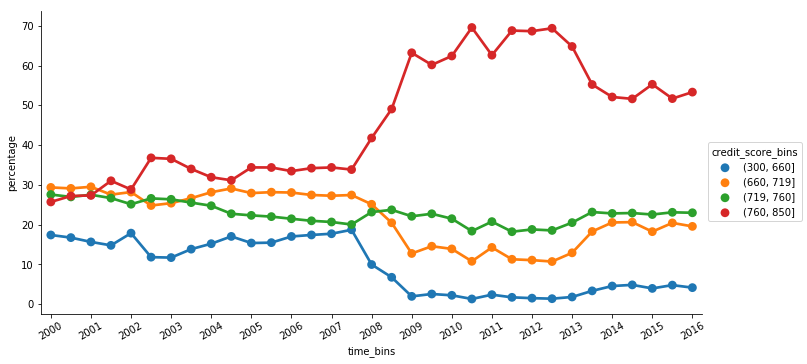

In [12]:
# Assign data a bin by credit scores
data['credit_score_bins'] = pd.cut(data['borrower_credit_score'], [300, 660, 719, 760, 850])

# Group data into time and credit score bins, calculate 
# percent in each bin for a give year
time_credit_score_group = data.groupby(['time_bins', 'credit_score_bins']).size()
score_pcts = time_credit_score_group.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

# Rename percentage bin
score_pcts = score_pcts.reset_index().rename(columns={0:'percentage'})

# Plot 
ax = sns.factorplot(x='time_bins', y = 'percentage', hue = 'credit_score_bins', data = score_pcts, size=5, aspect=2)
plt.locator_params(axis='x', nbins=18)
ax.set_xticklabels(range(2000, 2017, 1), rotation=30);

Prior to 2008, nearly half of all loans had credit scores below 760.  Now, the bulk of loans are to borrowers who are considered more responsible and very few, less than 20$\%$, are to riskier individuals.

When performing quantitative analyses, it is always best to use all the data at your disposal.  However, when constructing models to be used for prediction, care must be taken to ensure the behavior of the system reflects current reality.  This clear change in lending behavior indicates we essentially have two distinct mortgage groups in our data.  To remove this time dependence, we will include mortgages initiated after 2008 when the stricter borrowing standards were implemented.

In [13]:
data = data[data['origination_date'] > 2008.]

## Model Fitting

Now, it's finally time to model the data and see if we can weed out likely foreclosures.  We will first start with a simpler logistic model and the use the a random forest to tease out additional features.  To keep the notebook tidy, the routines are external, but check them out if you would like to a bit more detail.

The basic challenge is to take the data provided by Fannie Mae and determine if we can produce more stringent criteria for lending.  Common to both these models, we will first do some filtering to remove certain columns we deem unnecessary and rows with missing values.  The non-foreclosed mortgages are also downsampled to achieve better balance with the number of foreclosures to avoid sensitivity in the classifiers.

Columns were primarily removed if they are uninformative or if they were degenerate with other features.  For instance, the foreclosure date and recovery cost columns were removed because they were obviously created after a home has foreclosed.  Additionally, we added the time_bins and credit_score_bins columns, so they need to be excluded.  To remove degeneracies we need to exclude columns that are derivatives of other values or correlated.  There is a subtle time dependence in the data (discussed below) so no form of time is explicitly included.  This is a bit of a judgment call, but it is one we have to make since we will use this model to predict which loans to grant and which to reject in the future.

Finally, the interest rate is excluded.  With the exception of the origination date, this feature is actually the best predictor and its inclusion boosts the relative performance by over 10$\%$. However it is determined by several other, more basic factors which we have directly or have proxies.  Specifically, it depends on the borrower's credit score, home location, down payment, loan term, rate type (fixed or adjustable), and loan type.  There is a good case for keeping it in our fitting since it plays a large role in what consumers pay each month and how they make decisions, but it is worth excluding for now.  Individually, the interest rate doesn't depend very strongly on other parameters, but each contains a small or moderate correlation that contributes in aggregate.

In [14]:
print 'Interest Rate - Credit Score Correlation = ', data['interest_rate'].corr(
                            data['borrower_credit_score'], method='pearson')
print 'Interest Rate - Debt Level = ', data['interest_rate'].corr(
                            data['cltv'], method='pearson')
print 'Interest Rate - Loan Term = ', data['interest_rate'].corr(
                            data['loan_term'], method='pearson')

Interest Rate - Credit Score Correlation =  -0.22404378304005337
Interest Rate - Debt Level =  0.11978275423656623
Interest Rate - Loan Term =  0.4052260301211376


Besides simply looking at the number of true positives, false positives, true negatives, and false negatives, we can apply a set of performance metrics to quantify the fidelity of a certain model.  For both models, we can consider the:
 - Accuracy - The ratio of well the predictions match exactly
 - Precision - The ratio of the correctly predicted positives to the total predicted positives, TP/(TP+FP)
 - Recall - The ratio of correctly predicted positives to all in the actual class, TP/(TP+FN)
 - F1 Score - A weighted average of precision and recall
 - Log-Loss Score - negative log-likelihood of the true values, essentially like a confidence score

## Logistic Fit

To fit the Logit function, we will split the data into subsets for training and testing.  For the training, we will use a k-folds cross validation to maximize our data usage and then predict with this model to compare tp the testing data.  This will give us an idea for how it will perform when applied to new mortgages.

In [15]:
log_model, log_predictions = make_logistic_predictions(data)

Dropped 1.0% of data in filtering
Accuracy Score =  0.704910939640874
True Neg =  13095    False Pos =  5394    False Neg =  2790    True Pos =  6455
             precision    recall  f1-score   support

        0.0       0.82      0.71      0.76     18489
        1.0       0.54      0.70      0.61      9245

avg / total       0.73      0.70      0.71     27734

Log-Loss Score =  0.5667824117575099


The logistic model serves as our baseline model and even so, it does surprisingly well.  With an accuracy score of 0.70, it is correct ~70$\%$ of the time which is much better than just randomly guessing.  When it predicts non-foreclosures it predicts them well, but is able to correctly predict foreclosures accurately just over half of the time.  The two recall scores are comparable to the accuracy score for both the foreclosures and non-foreclosures, so we have ~70$\%$ accuracy for a given classification

Ideally we'd like something more sophisticated that can better pick out the nuances of foreclosures.  One candidate are decision trees which offer a great way to find complex nonlinear relations within the data.  In short, this algorithm works by defining conditions on nodes based on features in the data.  Branches fork from nodes until the decision is reached at the final "leaf."  The methods are great for classification, but they can become too large and overfit the data by fitting specific points.  This sensitivity to the exact data manifests as high variance.  This can be corrected by creating an ensemble of decision trees that are each given random subsets of the data, letting them fit the data, and then aggregating the features based on their overall importance. 

Unlike the logistic models, the performance of a random forest model isn't solely dictated by the data and the conditions that describe outcomes.  Random forests also have hyperparameters that set the number of trees used in the estimation, the maximum tree depth, and the number of data points that can trigger a split.  Rather than set these ourselves, a search through the hyperparameter space can help mitigate the influence of overfitting or underfitting based on preassigned values to optimize the fit.  The hyperparamters here are determined this way and the parameters used are printed below.

In [16]:
rf_model, rf_predictions = make_rand_forest_predictions(data)

Dropped 1.0% of data in filtering
Best parameters for random forest classification are  {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 320, 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': None}
(27734, 2)
Accuracy Score =  0.8024085959472128
True Neg =  15897    False Pos =  2592    False Neg =  2888    True Pos =  6357
             precision    recall  f1-score   support

        0.0       0.85      0.86      0.85     18489
        1.0       0.71      0.69      0.70      9245

avg / total       0.80      0.80      0.80     27734

Log-Loss Score =  0.44580644909939565


This model performs fairly well.  Overall this model is superior to the logistic model in accuracy and precision, but it is worth noting it misses more true defaults at than the logistic model.  Diving into the model a bit, we can see which features are most important.

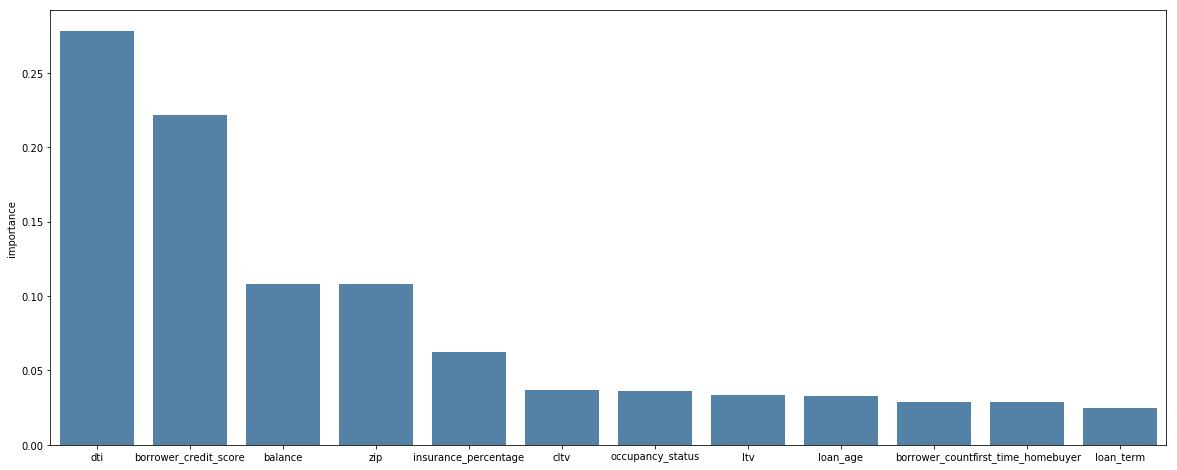

In [17]:
# Fetch importances of featues in random forest model
importances = get_importances(rf_predictions.columns[:-4], rf_model)

# Plot features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
sns.barplot(importances.index, importances['importance'], color='steelblue');

This is consistent with expectations.  The overall amount borrowed and the ratio of debt to their income causes problems.  If your mortgage is too expensive and you don't have a protective cushion, a lack of liquidity could cause you to default on your mortgage.  Additionally, the importance of credit score tells us that borrowers with troublesome credit histories may have issues handling future debt.  Conversely, those that manage debt well, can be trusted with future credit.  Finally, the home location is important because certain areas have inflated home prices (thing San Fransisco vs a small rural town) and may be prone to local fluctuations in housing markets that can modulate the foreclosure rate. 

As previously mentioned, there is a time dependence in the accuracy of the model.  If we take the false positives from the random forest model and bin them according to time, we see the ages tend to be found at the longest duration sampled (9 years).

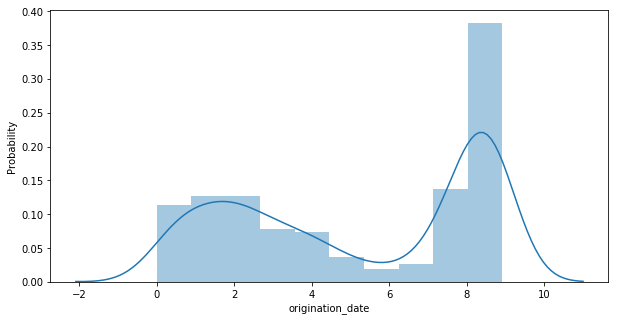

In [18]:
# Pick out false positives from predictions
false_neg = rf_predictions[(rf_predictions['foreclosure']==0) & (rf_predictions['prediction']==1)]
# Plot distribution of current ages
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.distplot(2017.-false_neg['origination_date'])
ax.set_ylabel('Probability');

What could this mean?  Near our time cut, the market was recovering from the subprime mortgage crisis and lending standards were changing, so a few risky loans may have snuck on to the balance sheet.  Alternatively, these may be mortgages that haven't defaulted yet, but may in the future.  As we saw earlier, there is a long-tail in the ownership lifetime of foreclosed homes.  Thinking in terms of the probability distribution function, foreclosure is much less likely since they are over the 5-year hump, but in terms of the cumulative distribution function, these mortgages aren't out of the woods yet.  It turns out a ~15$\%$ of all mortgages default after 9 years, which could account for a portion of the false positives in the models (~10$\%$ FP rate).

In [19]:
lifetime = age_data['foreclosure_date']-age_data['origination_date']
lifetime = lifetime.sort_values()
fraction = float(lifetime[lifetime > 9.].size)/float(lifetime.size)
print 'Probability of default beyond 9 years = ', fraction

Probability of default beyond 9 years =  0.145986167522


As a final diagnostic of the random forest model quality, we will use the receiver operating characteristic (ROC) curve.  This curve measures the changes in the true positive and negative rates the discrimination threshold is changed.  A resilient model has very little change in the false positive rate as you enforce a  tougher criterion.  This translates into a curve in TP-FP space that ideally lies in the upper left corner, meaning you are more likely to have a real detection than a false alarm.

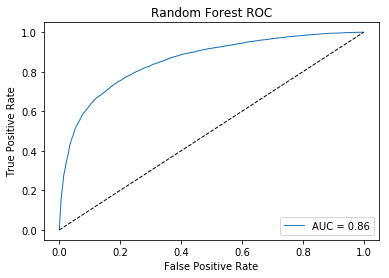

In [20]:
# Calculate receiver operating characteristic curve from prediction probabilities
fpr, tpr, thresholds = roc_curve(rf_predictions['foreclosure'], rf_predictions['probability'])
# Calculate "area under the curve"
roc_auc = roc_auc_score(rf_predictions['foreclosure'], rf_predictions['probability'])

# Plot ROC curve
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right", frameon = True);

This model does well with an "area under the curve" score of 0.93.

# Application

Here we've take a dive into the Fannie Mae mortgage dataset.  Across the web this data has been looked at in many ways and I've tried to do something a bit different.  We've found a number of neat things including a clear change in the lending standards from 2008 onwards, the distribution of mortgages ages before they enter foreclosure, and developed two machine learning models to better predict foreclosures.  This information could be used to avoid purchasing bad loans or to avoid granting the loans in the first place.  We've taken the position of a lender at the beginning of the mortgage, but next I plan to look at maintaining them by using the payment history and changes in interest rates to predict which loans may need to be removed from the balance sheet.  Stay tuned!